<a href="https://colab.research.google.com/github/poisonkissedsk/Production-Grade-AI-QA-Suite/blob/main/Robustness_%26_Stress_Testing_(Perturbation_%26_Adversarial_Inputs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1-3300568121.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric] = StandardScaler().fit_transform(X[numeric])


Average Prediction Score Change: 0.0057
Max Prediction Score Change: 0.0231
Prediction Flips After Perturbation: 0 out of 100 samples


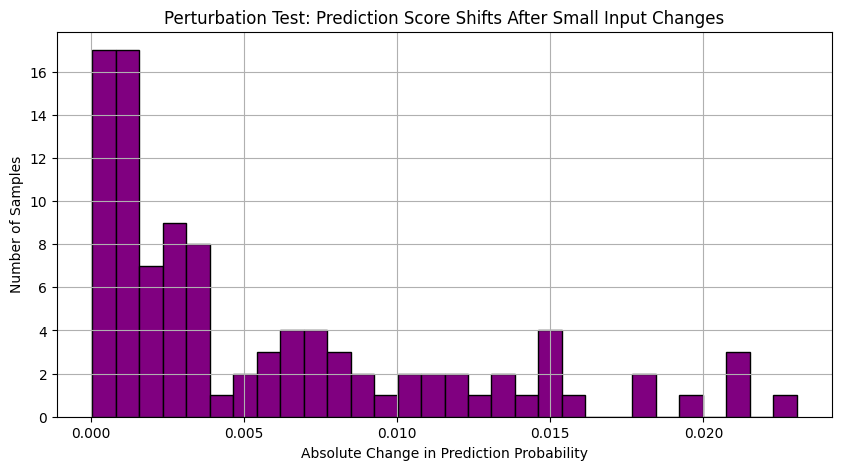


Adversarial Test: Average Prediction Score Change: 0.7491
Adversarial Test: Max Prediction Score Change: 0.9958


In [ ]:
# 📒 Notebook 3: Robustness & Stress Testing (Perturbation & Adversarial Inputs)
# Goal: Evaluate model stability under small input changes (perturbation tests)

# -- SETUP --
!pip install scikit-learn pandas numpy matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# -- STEP 1: Load and Prepare Data --

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
df.dropna(inplace=True)
df['label'] = (df['income'] == '>50K').astype(int)

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

for col in categorical:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df[categorical + numeric]
y = df['label']

X[numeric] = StandardScaler().fit_transform(X[numeric])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# -- STEP 2: Train Screening Model --

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# -- STEP 3: Perturbation Testing --

# Select 100 random test samples for perturbation
sample_indices = np.random.choice(X_test.index, size=100, replace=False)
original_samples = X_test.loc[sample_indices].copy()
original_preds = model.predict_proba(original_samples)[:, 1]  # Get prediction probabilities

perturbed_samples = original_samples.copy()

# Introduce small perturbations: Add small noise to numeric features
perturbation_strength = 0.02  # Small change
perturbed_samples[numeric] += np.random.normal(0, perturbation_strength, perturbed_samples[numeric].shape)

# Re-predict after perturbation
perturbed_preds = model.predict_proba(perturbed_samples)[:, 1]

# Measure prediction shifts
score_deltas = np.abs(original_preds - perturbed_preds)
prediction_flips = (model.predict(original_samples) != model.predict(perturbed_samples)).sum()

print(f"Average Prediction Score Change: {score_deltas.mean():.4f}")
print(f"Max Prediction Score Change: {score_deltas.max():.4f}")
print(f"Prediction Flips After Perturbation: {prediction_flips} out of 100 samples")

# -- STEP 4: Visualize Perturbation Impact --

plt.figure(figsize=(10,5))
plt.hist(score_deltas, bins=30, color='purple', edgecolor='black')
plt.xlabel('Absolute Change in Prediction Probability')
plt.ylabel('Number of Samples')
plt.title('Perturbation Test: Prediction Score Shifts After Small Input Changes')
plt.grid()
plt.show()

# -- STEP 5: (Optional) Simulate Adversarial Inputs --

# Adversarial test: Set all numeric features to extreme values (simulate outliers)
adversarial_samples = original_samples.copy()
adversarial_samples[numeric] = 5.0  # Extreme standardized value

adversarial_preds = model.predict_proba(adversarial_samples)[:, 1]

# Compare adversarial vs original
adversarial_deltas = np.abs(original_preds - adversarial_preds)

print(f"\nAdversarial Test: Average Prediction Score Change: {adversarial_deltas.mean():.4f}")
print(f"Adversarial Test: Max Prediction Score Change: {adversarial_deltas.max():.4f}")